In [1]:
import sys
sys.path.insert(0, '/home/knoop/local/vibes')

import importlib as il


import numpy as np

from matplotlib import pyplot as plt

from vibes.trajectory import reader
from vibes.konstanten import omega_to_THz

HA = il.import_module('vibes.harmonic_analysis')

In [2]:
traj = reader('no_drift.yaml')

.. no_drift.yaml parsed in 3.324s


In [3]:
fcs, lps = HA.parse_tdep_forceconstant('outfile.forceconstant')

Parse force constants from
  outfile.forceconstant
.. remap representation for supercell:  False
.. Number of atoms:   2
.. Real space cutoff: 3.660 \AA
.. Number of lattice points: 54 (33 unique)
.. time elapsed: 0.003s


In [4]:
il.reload(HA)
ha = HA.HarmonicAnalysis(traj.primitive, traj.supercell, fcs, lps)

Set up harmonic analysis for MgO:
.. found 32 (31) lattice points in 0.009s
.. matched 64 positions in supercell and primitive cell in 0.062s
.. found 32 (31) lattice points in 0.001s
.. time elapsed: 0.212s


In [5]:
Z_qst = ha.get_Zqst(traj)

Project trajectory onto modes:
100%|██████████| 7500/7500 [00:02<00:00, 2672.21it/s]


In [6]:
def compute_sed(Z_qst):
    """ Computes spectral energy density for complex amplitudes

    Args:
        Z_qst (np.ndarray [N_t, N_q, N_s]): complex amplitdues for a trajectory
    """
    
    velocities = Z_qst.copy()

    velocities = velocities.transpose(1, 2, 0).copy()
    velocities = np.fft.fft(velocities, axis=2)

    return velocities

In [7]:
seq = compute_sed(Z_qst)

In [8]:
tmax = traj[-1].info['nsteps'] * traj[-1].info['dt_fs']

In [9]:
xs = np.arange(len(traj)) / tmax * 1000

.. number of q points reduced from 32 to 8 in 0.200s
q 0 [0. 0. 0.]
[-1.64723663e-07 -1.64723663e-07  2.32954439e-07  1.35154996e+01
  1.35154996e+01  1.35154996e+01]


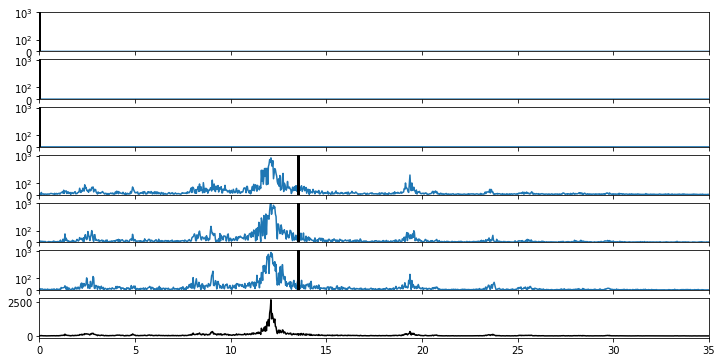

q 1 [0.   0.25 0.25]
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


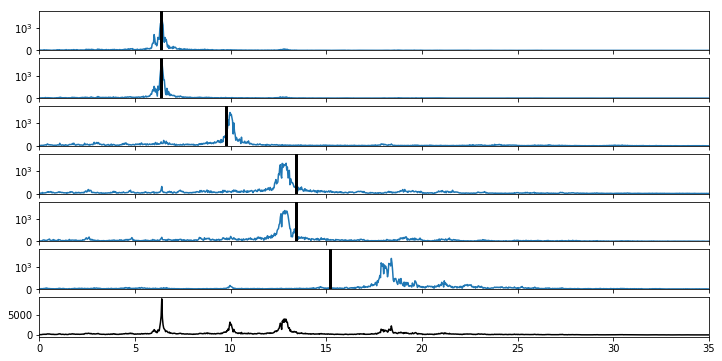

q 2 [0.  0.5 0.5]
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


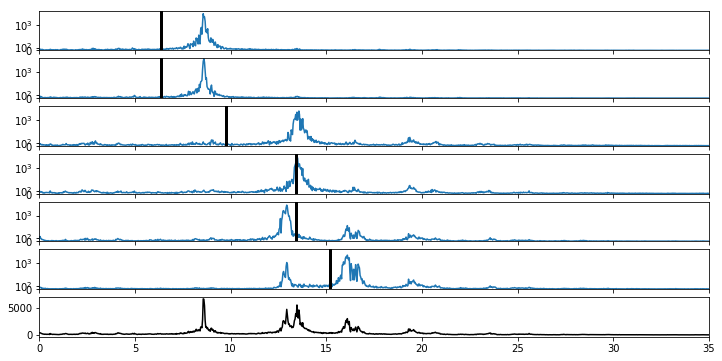

q 3 [0.   0.75 0.75]
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


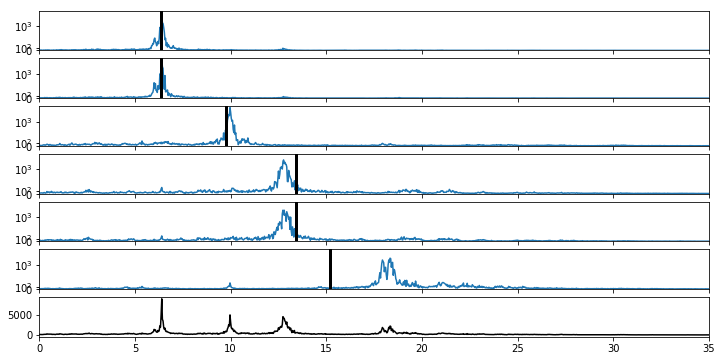

q 4 [0.25 0.25 0.5 ]
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


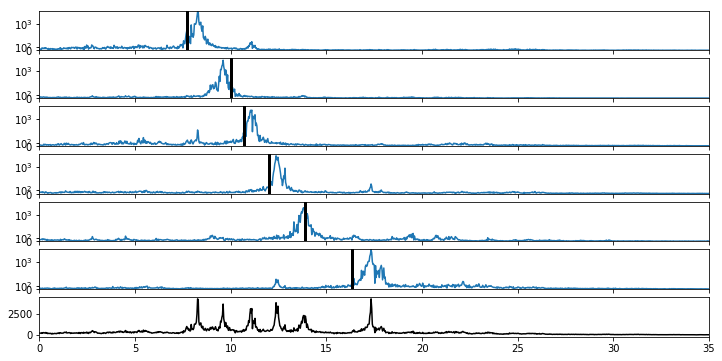

q 5 [0.25 0.5  0.75]
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


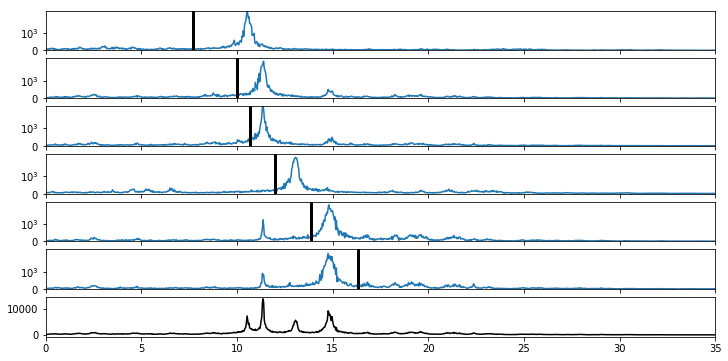

q 6 [0.5 0.5 0.5]
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


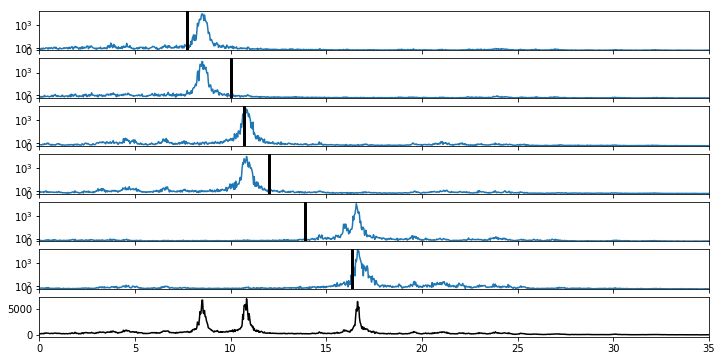

q 7 [0.5  0.75 0.75]
[ 7.80020015  7.80020015 10.6408771  10.6408771  15.11425487 17.36811989]


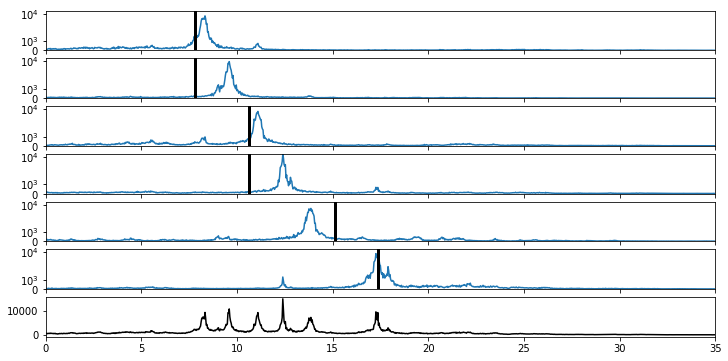

In [10]:
dblue = '#1f77b4'

mapping = ha.irreducible_q_points_mapping
omegas = ha.omegas

n_unique = len(np.unique(mapping))

for ii in np.unique(mapping):
    fig, axs = plt.subplots(nrows=seq.shape[1]+1, sharex=True, figsize=(12, 6))
    
    print(f'q {ii} {ha.irreducible_q_points_frac[ii]}')
    print(omegas[ii] * omega_to_THz)
    
    spec = abs(seq[mapping == ii])
    for b in range(seq.shape[1]):
        s = spec.sum(axis=(0))
        axs[b].plot(xs, s[b], color=dblue)
        axs[b].set_yscale('symlog', linthreshy=s.max() / 5)
        axs[b].set_ylim([0.01, 1.05 * s.max()])
        # plot 'analytic' frequencies
        w = omegas[ii, b] * omega_to_THz
        axs[b].axvline(w, color='k', linewidth=3)
        
    axs[-1].plot(xs, spec.sum(axis=(0, 1)), color='k')

    plt.xlim([0, 35])
    
    plt.show()